In [ ]:
#The method is based on this paper:
#Park, S.H., Kim, K. Collaborative filtering recommendation system based on improved Jaccard similarity. J Ambient Intell Human Comput 14, 11319–11336 (2023). https://doi.org/10.1007/s12652-023-04647-0
#Some parts of the code is modified based on: https://cseweb.ucsd.edu/~jmcauley/pml/code/chap4.html

In [ ]:
from collections import defaultdict
from csv import DictReader
import math
import time
import numpy
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#read interactions_train.csv from Google Drive
with open("drive/MyDrive/interactions_train.csv", 'r') as f:
    dict_reader = DictReader(f)
    data = list(dict_reader)

#change the data type for “rating” from string to float
for d in data:
  d['rating']=float(d['rating'])

In [ ]:
#randomly split the dataset into 90% for training and 10% for testing
from sklearn.model_selection import train_test_split
train, test= train_test_split(data, test_size=0.1, random_state=42)

In [ ]:
train[0]

{'user_id': '398216',
 'recipe_id': '146435',
 'date': '2009-04-13',
 'rating': 0.0,
 'u': '5824',
 'i': '29520'}

In [ ]:
usersPerItem = defaultdict(set) # Maps an item to the users who rated it
itemsPerUser = defaultdict(set) # Maps a user to the items that they rated
reviewsPerItem = defaultdict(list) # Maps an item to its reviews
ratingDict = {} # To retrieve a rating for a specific user/item pair

for d in train:
    user,item = d['user_id'], d['recipe_id']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)

    reviewsPerItem[item].append(d)

    ratingDict[(user,item)] = d['rating']


In [ ]:
userAverages = {}
ratingMean = []

for u in itemsPerUser:
    rs = [ratingDict[(u,i)] for i in itemsPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)

for d in train:
    ratingMean.append(d['rating'])

ratingMean = sum(ratingMean) / len(ratingMean)

In [ ]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [ ]:
#k-NN
k=100

In [ ]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [ ]:
def predictRating_Jaccard(user,item):
    ratings = []
    similarities = []
    k_NN=[]
    for d in reviewsPerItem[item]:
        u2 = d['user_id']
        if u2 ==user: continue
        ratings.append(d['rating'] - userAverages[u2])
        similarity=Jaccard(itemsPerUser[user],itemsPerUser[u2])
        similarities.append(similarity)
        k_NN.append((d['rating'] - userAverages[u2], similarity))
    if (sum(similarities) > 0):
        k_NN.sort(reverse=True, key=lambda a: a[1])
        weightedRatings = [(x*y) for x,y in k_NN[:k]]
        return userAverages[user] + sum(weightedRatings) / sum(similarities)
    elif (userAverages.get(user)!=None):
        return userAverages[user]
    else:
        return ratingMean

In [ ]:
labels = [d['rating'] for d in test]
begin=time.time()
Jaccard_predictions=[predictRating_Jaccard(d['user_id'], d['recipe_id']) for d in test]
end=time.time()
Jaccard_time= numpy.round(end - begin, 3)
Jaccard_MSE=MSE(Jaccard_predictions, labels)

In [ ]:
def RJAC_U(u1, u1_items, u2, u2_items):
    intersection=u1_items.intersection(u2_items)
    count=0
    for i in intersection:
      if ratingDict[u1, i]==ratingDict[u2, i]:
        count+=1
    numer = count
    denom = len(u1_items.union(u2_items))
    if denom == 0:
        return 0
    return numer / denom

In [ ]:
def predictRating_RJAC_U(user,item):
    ratings = []
    similarities = []
    k_NN=[]
    for d in reviewsPerItem[item]:
        u2 = d['user_id']
        if u2 == user: continue
        ratings.append(d['rating'] - userAverages[u2])
        similarity=RJAC_U(user, itemsPerUser[user], u2, itemsPerUser[u2])
        similarities.append(similarity)
        k_NN.append((d['rating'] - userAverages[u2], similarity))
    if (sum(similarities) > 0):
        k_NN.sort(reverse=True, key=lambda a: a[1])
        weightedRatings = [(x*y) for x,y in k_NN[:k]]
        return userAverages[user] + sum(weightedRatings) / sum(similarities)
    elif (userAverages.get(user)!=None):
        return userAverages[user]
    else:
        return ratingMean

In [ ]:
labels = [d['rating'] for d in test]
begin=time.time()
RJAC_U_predictions=[predictRating_RJAC_U(d['user_id'], d['recipe_id']) for d in test]
end=time.time()
RJAC_U_time= numpy.round(end - begin, 3)
RJAC_U_MSE=MSE(RJAC_U_predictions, labels)

In [ ]:
def RJAC_D(u1, u1_items, u2, u2_items, theta):
    intersection=u1_items.intersection(u2_items)
    count=0
    for i in intersection:
      if abs(ratingDict[u1, i]-ratingDict[u2, i])<=theta:
        count+=1
    numer = count
    denom = len(u1_items.union(u2_items))
    if denom == 0:
        return 0
    return numer / denom

In [ ]:
def predictRating_RJAC_D(user, item, theta):
    ratings = []
    similarities = []
    k_NN=[]
    for d in reviewsPerItem[item]:
        u2 = d['user_id']
        if u2 == user: continue
        ratings.append(d['rating'] - userAverages[u2])
        similarity=RJAC_D(user, itemsPerUser[user], u2, itemsPerUser[u2], theta)
        similarities.append(similarity)
        k_NN.append((d['rating'] - userAverages[u2], similarity))
    if (sum(similarities) > 0):
        k_NN.sort(reverse=True, key=lambda a: a[1])
        weightedRatings = [(x*y) for x,y in k_NN[:k]]
        return userAverages[user] + sum(weightedRatings) / sum(similarities)
    elif (userAverages.get(user)!=None):
        return userAverages[user]
    else:
        return ratingMean

In [ ]:
labels = [d['rating'] for d in test]
theta=1
begin=time.time()
RJAC_D_predictions=[predictRating_RJAC_D(d['user_id'], d['recipe_id'], theta) for d in test]
end=time.time()
RJAC_D_time= numpy.round(end - begin, 3)
RJAC_D_MSE=MSE(RJAC_D_predictions, labels)

In [ ]:
def RJAC_DUB(u1, u1_items, u2, u2_items, theta):
    intersection=u1_items.intersection(u2_items)
    count=0
    for i in intersection:
      if abs((ratingDict[u1, i]-userAverages[u1])-(ratingDict[u2, i]-userAverages[u2]))<=theta:
          count+=1
    numer = count
    denom = len(u1_items.union(u2_items))
    if denom == 0:
        return 0
    return numer / denom

In [ ]:
def predictRating_RJAC_DUB(user, item, theta):
    ratings = []
    similarities = []
    k_NN=[]
    for d in reviewsPerItem[item]:
        u2 = d['user_id']
        if u2 == user: continue
        ratings.append(d['rating'] - userAverages[u2])
        similarity=RJAC_DUB(user, itemsPerUser[user], u2, itemsPerUser[u2], theta)
        similarities.append(similarity)
        k_NN.append((d['rating'] - userAverages[u2], similarity))
    if (sum(similarities) > 0):
        k_NN.sort(reverse=True, key=lambda a: a[1])
        weightedRatings = [(x*y) for x,y in k_NN[:k]]
        return userAverages[user] + sum(weightedRatings) / sum(similarities)
    elif (userAverages.get(user)!=None):
        return userAverages[user]
    else:
        return ratingMean

In [ ]:
labels = [d['rating'] for d in test]
theta=1
begin=time.time()
RJAC_DUB_predictions=[predictRating_RJAC_DUB(d['user_id'], d['recipe_id'], theta) for d in test]
end=time.time()
RJAC_DUB_time= numpy.round(end - begin, 3)
RJAC_DUB_MSE=MSE(RJAC_DUB_predictions, labels)

In [ ]:
def WRJAC_DUB(u1, u1_items, u2, u2_items, theta1, theta2, w1, w2):
    intersection=u1_items.intersection(u2_items)
    count1=0
    for i in intersection:
      if abs((ratingDict[u1, i]-userAverages[u1])-(ratingDict[u2, i]-userAverages[u2]))<=theta1:
          count1+=1
    count2=0
    for i in intersection:
      if abs((ratingDict[u1, i]-userAverages[u1])-(ratingDict[u2, i]-userAverages[u2]))<=theta2:
          count2+=1
    numer = count1*w1+count2*w2
    denom = len(u1_items.union(u2_items))
    if denom == 0:
        return 0
    return numer / denom

In [ ]:
def predictRating_WRJAC_DUB(user, item, theta1, theta2, w1, w2):
    ratings = []
    similarities = []
    k_NN=[]
    for d in reviewsPerItem[item]:
        u2 = d['user_id']
        if u2 == user: continue
        ratings.append(d['rating'] - userAverages[u2])
        similarity=WRJAC_DUB(user, itemsPerUser[user], u2, itemsPerUser[u2], theta1, theta2, w1, w2)
        similarities.append(similarity)
        k_NN.append((d['rating'] - userAverages[u2], similarity))
    if (sum(similarities) > 0):
        k_NN.sort(reverse=True, key=lambda a: a[1])
        weightedRatings = [(x*y) for x,y in k_NN[:k]]
        return userAverages[user] + sum(weightedRatings) / sum(similarities)
    elif (userAverages.get(user)!=None):
        return userAverages[user]
    else:
        return ratingMean

In [ ]:
labels = [d['rating'] for d in test]
theta1=0.5
theta2=1
w1=1
w2=0.5
begin=time.time()
WRJAC_DUB_predictions=[predictRating_WRJAC_DUB(d['user_id'], d['recipe_id'], theta1, theta2, w1, w2) for d in test]
end=time.time()
WRJAC_DUB_time= numpy.round(end - begin, 3)
WRJAC_DUB_MSE=MSE(WRJAC_DUB_predictions, labels)

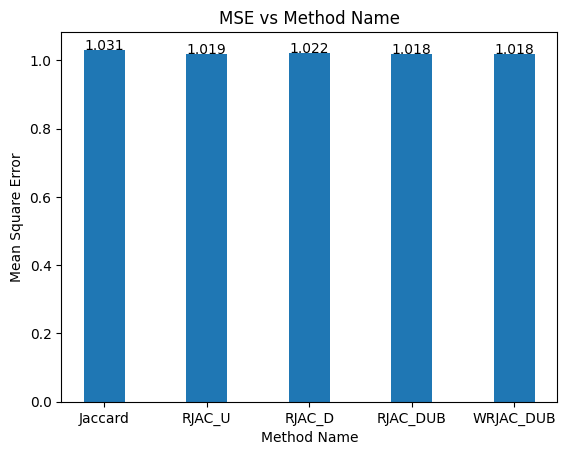

In [ ]:
MSE_list=[Jaccard_MSE, RJAC_U_MSE, RJAC_D_MSE, RJAC_DUB_MSE, WRJAC_DUB_MSE]
Method_Name=["Jaccard", "RJAC_U", "RJAC_D", "RJAC_DUB", "WRJAC_DUB"]
plt.bar(Method_Name, MSE_list, width = 0.4)
plt.title("MSE vs Method Name")
plt.xlabel('Method Name')
plt.ylabel('Mean Square Error')
for i in range(len(Method_Name)):
    plt.text(i, MSE_list[i], numpy.round(MSE_list[i], 3), ha = 'center')
plt.show()

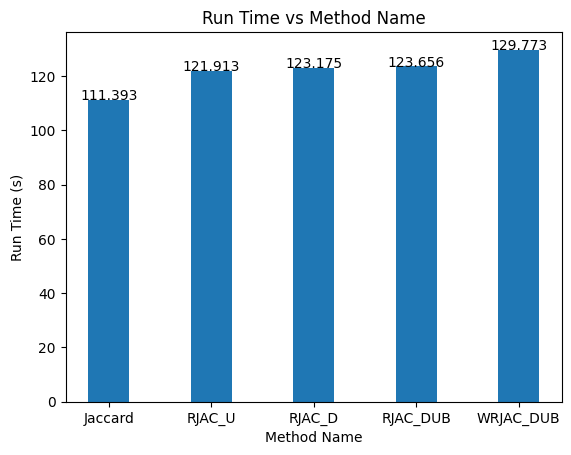

In [ ]:
time_list=[Jaccard_time, RJAC_U_time, RJAC_D_time, RJAC_DUB_time, WRJAC_DUB_time]
Method_Name=["Jaccard", "RJAC_U", "RJAC_D", "RJAC_DUB", "WRJAC_DUB"]
plt.bar(Method_Name, time_list, width = 0.4)
plt.title("Run Time vs Method Name")
plt.xlabel('Method Name')
plt.ylabel('Run Time (s)')
for i in range(len(Method_Name)):
    plt.text(i, time_list[i], numpy.round(time_list[i], 3), ha = 'center')
plt.show()